In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Gradient Boost Model

We'll use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [3]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# make the categorical variable 'country' into dummies
X = pd.concat([X, pd.get_dummies(df.cntry)], axis=1)

# .shape[0] is the total number of rows
# create testing and training set
offset = int(X.shape[0] * 0.9)

# put 90% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# put 10% in the test set
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier. Now our loss function can't be the residuals. Our options are "deviance", or "exponential". Deviance is used for logistic regression, and we'll try that here.

In [6]:
# we'll make 500 iterations, use 2-deep trees, and set our loss function
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# initialize and fit model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent type I errors:{}\n'
    'Percent type II errors:{}\n'
    'Test set accurayc:\n'
    'Percent type I errors:{}\n'
    'Percent type II errors:{}\n'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent type I errors:0.04650845608292417
Percent type II errors:0.17607746863066012
Test set accurayc:
Percent type I errors:0.06257668711656442
Percent type II errors:0.18527607361963191



In [7]:
table_train

col_0,0.0,1.0,All
partner,,,
0.0,4167,341,4508
1.0,1291,1533,2824
All,5458,1874,7332


In [8]:
table_test

col_0,0.0,1.0,All
partner,,,
0.0,454,51,505
1.0,151,159,310
All,605,210,815


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface. But they aren't quite a black box. We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

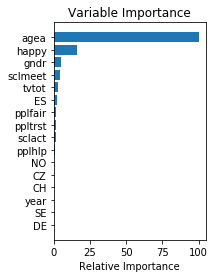

In [15]:
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance/feature_importance.max())
# argsort returns the indices/index that would sort an array.
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [16]:
feature_importance

array([2.71891856e-01, 3.02959385e+00, 1.41563989e+00, 1.70063921e+00,
       1.23082274e+00, 1.65013912e+01, 4.19881458e+00, 1.38297465e+00,
       5.11407664e+00, 1.00000000e+02, 3.53378101e-01, 5.32879423e-01,
       7.26665721e-02, 2.03125711e+00, 5.55388239e-01, 2.19071330e-01])

In [17]:
sorted_idx

array([12, 15,  0, 10, 11, 14,  4,  7,  2,  3, 13,  1,  6,  8,  5,  9],
      dtype=int64)

In [18]:
sorted_idx.shape[0]

16

In [19]:
pos

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5])

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Let's see how low we can get the error rates to go in the test set, based on our model in the training set.  Strategies we use include:

* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [20]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [28]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

# we'll make 1000 iterations, use 4 max-depth deep trees, and set our loss function to exponential
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'exponential'}

# initialize and fit model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, y)
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=None)
scores = cross_val_score(clf, X, y, cv=cv)

y_preds = clf.predict(X)

# accuracy tables
table = pd.crosstab(y, y_preds, margins=True)

tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']


print(('Cross_validation accuracy:{}\n'
    'Percent type I errors:{}\n'
    'Percent type II errors:{}\n'
).format(scores, tI_errors, tII_errors))

Cross_validation accuracy:[0.72017673 0.73588611 0.72238586 0.72042219 0.72238586 0.72238586
 0.72631321 0.7317133  0.72778596 0.71502209]
Percent type I errors:0.01282051282051282
Percent type II errors:0.08496999454446263



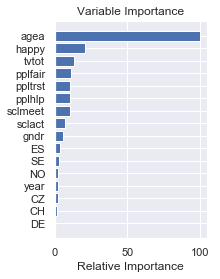

In [29]:
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance/feature_importance.max())
# argsort returns the indices/index that would sort an array.
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

 Error rates improve as we increase the iterations, deepen the tree to 16 leaves, and change the loss function to 'exponential'.


# Neural Network Model

### 2 layers of 100 and 250 perceptrons each

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(hidden_layer_sizes=(100,250))
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8224222585924713


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.62644853 0.48534424 0.7402863  0.75170532 0.72832765]


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [5]:
from sklearn.metrics import confusion_matrix

y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[434,  71],
       [146, 164]], dtype=int64)

### Adding more perceptrons but only 1 layer

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

0.7614566284779051


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.62235855 0.4805726  0.74982958 0.73874488 0.75221843]


In [7]:
y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[421,  84],
       [131, 179]], dtype=int64)

### 2 perceptron layers at 250 and 100 with alpha and learning rate

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(250,100), alpha=1e-03, learning_rate='adaptive')
mlp.fit(X_train,y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

0.7731860338243317


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.63735515 0.48261759 0.74437628 0.74010914 0.75494881]


In [9]:
y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[443,  62],
       [151, 159]], dtype=int64)

### 2 layers of 100 and 250 perceptrons each with alpha and learning rate

In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(100,250), alpha=1e-03, learning_rate='adaptive')
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8240589198036007
[0.64212679 0.4805726  0.76891616 0.74761255 0.73856655]


In [13]:
y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[386, 119],
       [126, 184]], dtype=int64)

### GridSearch Neural Network

In [14]:
mlp = MLPClassifier(max_iter=100)

# define hyperparameters to try out
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# run gridsearch
from sklearn.model_selection import GridSearchCV

# n_jobs=-1 to max out all cpu cores
bestmlp = GridSearchCV(mlp, parameters, n_jobs=-1, cv=5)
bestmlp.fit(X_train, y_train)
y_pred = bestmlp.predict(X_test)

# Best paramete set
print('Best parameters:\n', bestmlp.best_params_)

# All results
from sklearn.metrics import classification_report

print(bestmlp.score(X_train,y_train))
print(cross_val_score(bestmlp,X_train,y_train,cv=5))
print(confusion_matrix(y_test,y_pred))
print('Results on the test set:')
print(classification_report(y_test, y_pred))

Best parameters:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.754228041462084


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.75187457 0.47852761 0.74369461 0.7585266  0.75290102]
[[452  53]
 [161 149]]
Results on the test set:
              precision    recall  f1-score   support

         0.0       0.74      0.90      0.81       505
         1.0       0.74      0.48      0.58       310

   micro avg       0.74      0.74      0.74       815
   macro avg       0.74      0.69      0.70       815
weighted avg       0.74      0.74      0.72       815



C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [15]:
mlp = MLPClassifier(max_iter=100)

# define hyperparameters to try out
parameters = {
    'hidden_layer_sizes': [(40,40,40), (50,50,50)],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'alpha': [0.00001, 0.0001],
    'learning_rate': ['constant'],
}

# run gridsearch
from sklearn.model_selection import GridSearchCV

# n_jobs=-1 to max out all cpu cores
bestmlp = GridSearchCV(mlp, parameters, n_jobs=-1, cv=5)
bestmlp.fit(X_train, y_train)
y_pred = bestmlp.predict(X_test)

# Best paramete set
print('Best parameters:\n', bestmlp.best_params_)

# All results
from sklearn.metrics import classification_report

print(bestmlp.score(X_train,y_train))
print(cross_val_score(bestmlp,X_train,y_train,cv=5))
print(confusion_matrix(y_test,y_pred))
print('Results on the test set:')
print(classification_report(y_test, y_pred))

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best parameters:
 {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (40, 40, 40), 'learning_rate': 'constant', 'solver': 'sgd'}
0.7515002727768685


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

[0.75732788 0.72256305 0.74301295 0.74624829 0.75494881]
[[437  68]
 [159 151]]
Results on the test set:
              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79       505
         1.0       0.69      0.49      0.57       310

   micro avg       0.72      0.72      0.72       815
   macro avg       0.71      0.68      0.68       815
weighted avg       0.72      0.72      0.71       815



C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [16]:
mlp = MLPClassifier(max_iter=100)

# define hyperparameters to try out
parameters = {
    'hidden_layer_sizes': [(30,30,30),(40,40,40)],
    'activation': ['tanh'],
    'solver': ['sgd'],
    'alpha': [0.000001, 0.00001],
    'learning_rate': ['constant'],
}

# run gridsearch
from sklearn.model_selection import GridSearchCV

# n_jobs=-1 to max out all cpu cores
bestmlp = GridSearchCV(mlp, parameters, n_jobs=-1, cv=5)
bestmlp.fit(X_train, y_train)
y_pred = bestmlp.predict(X_test)

# Best paramete set
print('Best parameters:\n', bestmlp.best_params_)

# All results
from sklearn.metrics import classification_report

print(bestmlp.score(X_train,y_train))
print(cross_val_score(bestmlp,X_train,y_train,cv=5))
print(confusion_matrix(y_test,y_pred))
print('Results on the test set:')
print(classification_report(y_test, y_pred))

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best parameters:
 {'activation': 'tanh', 'alpha': 1e-06, 'hidden_layer_sizes': (30, 30, 30), 'learning_rate': 'constant', 'solver': 'sgd'}
0.7456355701036552


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

[0.76141786 0.72392638 0.732788   0.75102319 0.73583618]
[[443  62]
 [150 160]]
Results on the test set:
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       505
         1.0       0.72      0.52      0.60       310

   micro avg       0.74      0.74      0.74       815
   macro avg       0.73      0.70      0.70       815
weighted avg       0.74      0.74      0.73       815



C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(100,250), alpha=1e-06, learning_rate='constant', activation= 'tanh', solver= 'sgd')
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

0.7573649754500819


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.76278119 0.72528971 0.75051125 0.74283765 0.75494881]


array([[450,  55],
       [159, 151]], dtype=int64)

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(100,250), alpha=1e-06, learning_rate='constant', activation= 'logistic', solver= 'sgd')
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7340425531914894


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

[0.75528289 0.71915474 0.73960464 0.72169168 0.71604096]


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[455,  50],
       [173, 137]], dtype=int64)

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(500,250), alpha=1e-06, learning_rate='constant', activation= 'logistic', solver= 'sgd')
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7375886524822695


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

[0.75460123 0.71642808 0.74642127 0.72783083 0.72081911]


C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[460,  45],
       [172, 138]], dtype=int64)

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(1000,), alpha=1e-06, learning_rate='constant', activation= 'logistic', solver= 'sgd')
mlp.fit(X_train, y_train)
print(mlp.score(X_train,y_train))
print(cross_val_score(mlp,X_train,y_train,cv=5))

y_pred = mlp.predict(X_test)
confusion_matrix(y_test,y_pred)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7527277686852155
[0.7661895  0.73006135 0.76005453 0.74420191 0.74812287]


array([[443,  62],
       [160, 150]], dtype=int64)

# Overall:

* Neural Network generally performs better than the Gradient Boost model.
* Depends on the numbers of perceptrons and the hidden layers, neural network can take longer time to run, especially when combined with GridSearch then the run time takes significantly longer.
* I had better accuracy score when I increase the size of the hidden layers to 1000. 
* Decreasing alpha level while also decreasing the number of perceptrons help addressing the overfitting issue, abeit at lower accuracy score on the training test.
* I end up changing the activation method to logistic instead of the recommended tanh because this is a classification task; however, the accuracy scores also drop.